In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [3]:
directory = "./synthetic-data"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

print(files)

['rx_times.txt', 'background.txt', 'target_30.txt', 'target_45.txt', 'target_0.txt', 'rx_locs.txt', 'target_15.txt']


In [4]:
files

['rx_times.txt',
 'background.txt',
 'target_30.txt',
 'target_45.txt',
 'target_0.txt',
 'rx_locs.txt',
 'target_15.txt']

In [5]:
files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")

In [6]:
dobs_dict = {}

for f in files: 
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")

# create survey

In [7]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [8]:
data_dict = {}

for key, value in dobs_dict.items(): 
    data_dict[key] = Data(survey=full_survey, dobs=value, relative_error=0.05)

In [9]:
ind = 25
rx_locs[ind, :]

array([ 5.,  0., 30.])

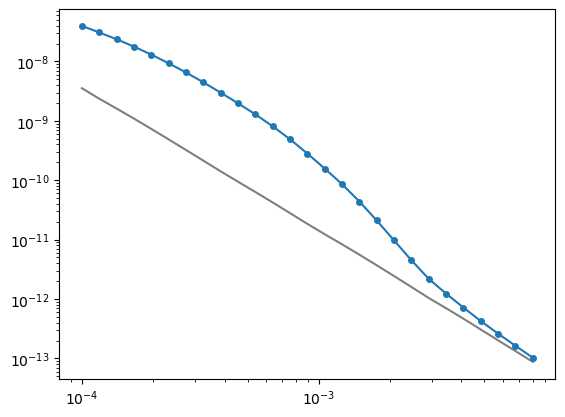

In [10]:
key = "target_0"
ind = 25
src = full_survey.source_list[ind]

plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
plt.loglog(rx_times, -data_dict[key][src, src.receiver_list[0]], "C0-o", ms=4)

In [15]:
mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

In [16]:
time_steps = [
    (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 20), (1e-4, 20), (3e-4, 20)
]

In [21]:
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

In [24]:
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

survey = tdem.Survey(source_list)

In [25]:
# global_sim = tdem.simulation.Simulation3DElectricField(
#     mesh=mesh,
#     survey=survey,
#     time_steps=time_steps,
#     solver=Solver,
#     sigmaMap=maps.ExpMap() * active_cells_map
# )

In [30]:
refine_depth = 180 # refine our local mesh to 200m 
mesh_list = []

for src in source_list: 
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    
    # refine near transmitters and receivers
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]], np.r_[src.location[1]], np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points, level=-2, #-1 
        padding_cells_by_level=[2, 4, 4], 
        finalize=True, diagonal_balance=True
    )
    mesh_list.append(mesh_local)

In [31]:
len(mesh_list)

51

In [32]:
mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)
    
    local_actmap = maps.InjectActiveCells(
        local_mesh, 
        active_cells=tile_map.local_active, 
        value_inactive=np.log(1e-8)
    )
    
    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )

sim = MultiprocessingMetaSimulation(sims, mappings)


In [29]:
sim

In [14]:
# set up 1D inversion 
def create_inversion(
    key, ind, dobs, n_times_invert=20, 
): 
    relative_error=0.1
    noise_floor=1e-11
    alpha_s = 1e-1
    alpha_x = 1
    rho_back = 500
    beta0 = 10
    
    rx_times_invert = rx_times[:n_times_invert]
    
    # def create inv
    # src = full_survey.source_list[ind]
    # rx = src.receiver_list[0]
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )
    
    data_invert = Data(
        survey_sounding, 
        dobs=dobs[:n_times_invert],
        relative_error=relative_error,
        noise_floor=noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=10)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    # starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False, name=f"inv-dict-{rx.locations[0,0]}"
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        # update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [15]:
directory = "./synthetic-invs-1d"

In [16]:
def run_inv(key, ind, dobs): 
    inv = create_inversion(key, ind, dobs)
    rho_start = 500
    m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
    
    label_key=f"{key}_{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt


In [17]:
# key = "target_0"
# n_times_invert = 20
# ind = 0
# src = full_survey.source_list[ind]
# rx = src.receiver_list[0]
# dobs = data_dict[key][src, rx][:n_times_invert]

# inv = create_inversion(key, ind, dobs)

In [18]:
    # rho_start = 500
    # m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
    # mopt = inv.run(m0)
    


In [19]:
# iterations = len(inv.directiveList.dList[-2].outDict)

In [20]:

# # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# # plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
# rx_times_invert = rx_times[:n_times_invert]
# plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
# plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

In [21]:

# rho_back = 500
# sigma_back = 1./rho_back 

# rho_target = 20
# sigma_target = 1./rho_target
# target_z_center = -60
# target_thickness = 40

# model_true = np.log(1/np.r_[rho_back, rho_target, rho_back])

# thicknesses_true = np.r_[-target_z_center - target_thickness/2, target_thickness]

In [22]:
# fig, ax = plt.subplots(1, 1, figsize=(2, 4))
# plot_1d_layer_model(
#     thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
# )
# plot_1d_layer_model(
#     thicknesses_true, np.exp(model_true), ax=ax, color="k", label="true"
# )
# ax.set_ylim([250, 0])
# ax.set_xlim([1e-4, 1e-1])


In [23]:
model_keys = list(data_dict.keys())[1:]
model_keys

['target_30', 'target_45', 'target_0', 'target_15']

In [24]:
rx_locs.shape

(51, 3)

In [25]:
inv_dict = {}
n_times_invert = 20

# key = model_keys[0]
with ProcessPoolExecutor() as executor:
    futures = []
    for key in model_keys: 
        for ind in range(rx_locs.shape[0]): 
            src = full_survey.source_list[ind]
            rx = src.receiver_list[0]
            dobs = data_dict[key][src, rx][:n_times_invert]
            futures.append(
                executor.submit(run_inv, key, ind, dobs)
            )
            
    for future in as_completed(futures):
        label_key, mopt = future.result()
        inv_dict[label_key] = mopt


Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0

simpeg.InvProblem will set Regularization.reference_model to m0.simpeg.InvProblem will set Regularization.reference_model to m0.
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0


In [26]:
target_0_keys = [k for k in inv_dict.keys() if "target_0" in k]

In [27]:
recovered_models = {}

for k in model_keys:
    recovered_models[k] = np.vstack([
        inv_dict[f"{k}_{ind}"] for ind in range(rx_locs.shape[0])
    ]).T

In [28]:
mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [40]:
with open("./synthetic-data/true-models.pkl", "rb") as f:
    true_models = pickle.load(f)

In [43]:
tree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


In [64]:
key = "target_0"

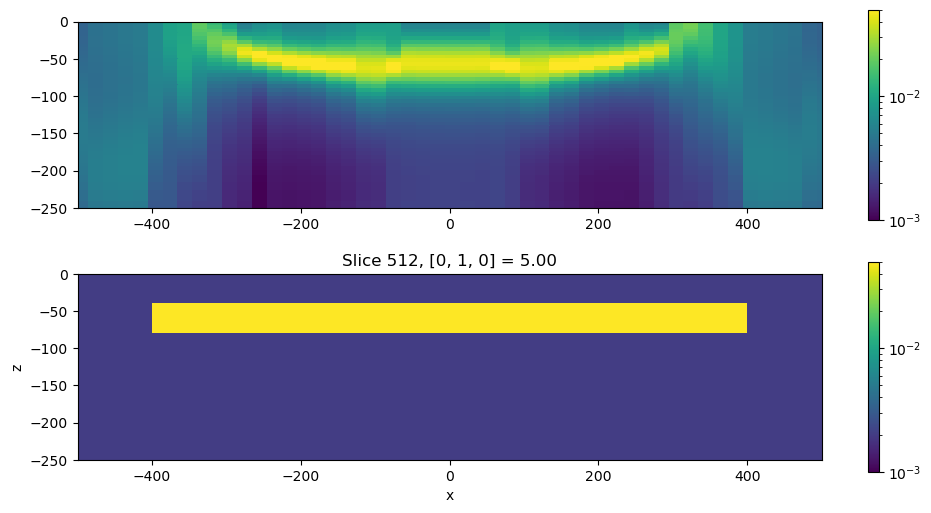

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

norm = LogNorm(vmin=1e-3, vmax=1/20)

plt.colorbar(ax[0].pcolor(
    rx_locs[:, 0], -mesh_invert.cell_centers, np.exp(recovered_models[key]), norm=norm
), ax=ax[0])

plt.colorbar(
    tree_mesh.plot_slice(
        true_models[key], pcolor_opts={"norm":norm}, ax=ax[1],
        normal="y"
    )[0], ax=ax[1]
)

for a in ax: 
    a.set_ylim(np.r_[-250, 0])
    a.set_xlim(np.r_[-500, 500])
    a.set_aspect(1)